# Import Required Modules

In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import math
import cv2
from IPython.display import Image
# from PIL import Image
import skimage.io as io
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Set Tensorflow backend to avoid full GPU pre-loading

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.global_variables_initializer()
set_session(tf.Session(config = config))

# Load pre-trained Row-Column/Vanilla CNN model

- Row Column CNN pre-trained model can be downloaded from [here](https://github.com/jyotishp/rolling-shutter-correction/releases/download/rol-col-cnn-weights/weights.35-0.91.hdf5).
- Vanilla CNN pre-trained model can be downloaded from [here](https://github.com/jyotishp/rolling-shutter-correction/releases/download/vanilla-cnn-weights/vanilla-weights.45-1.17.hdf5).

In [3]:
model = load_model('src/weights.35-0.91.hdf5')

# Load the RS distorted image

In [4]:
# img_path = 'data/test/rs_images/all_souls_000002_23.jpg'
# img_path = 'data/test/rs_images/oxford_000719_108.jpg'
img_path = 'data/test/rs_images/christ_church_000758_132.jpg'
# img_path = 'data/test/rs_images/christ_church_000333_95.jpg'
img = image.load_img(img_path)
src_img = cv2.imread(img_path)
img = image.img_to_array(img)
img = np.asarray([img])

# Predict the trajectory coefficients

In [5]:
predictions = model.predict([img])
predictions = predictions.reshape(15,2)
x = np.arange(15) * 25
tx_coeffs = np.polyfit(x, predictions[:,0], 2)
rz_coeffs = np.polyfit(x, predictions[:,1], 2)

# Compute Homographies from trajectory coefficients

In [6]:
def tx(x):
    x += 50
    return (tx_coeffs[0] * (x**2)) + (tx_coeffs[1] * x) + tx_coeffs[2]

def rz(x):
    x += 50
    return (rz_coeffs[0] * (x**2)) + (rz_coeffs[1] * x) + rz_coeffs[2]

In [7]:
def bilinearInterpolation(img, pred_pixel, channels = 3):
    row = pred_pixel[0]
    col = pred_pixel[1]
    row_lower = int(row)
    row_upper = row_lower + 1
    col_lower = int(col)
    col_upper = col_lower + 1

    weights = np.zeros(4)
    weights[0] = ( row_upper - row ) * ( col_upper - col )
    weights[1] = ( row_upper - row ) * ( col - col_lower )
    weights[2] = ( row - row_lower ) * ( col_upper - col )
    weights[3] = ( row - row_lower ) * ( col - col_lower )

    p0 = img[col_lower, row_lower]
    p1 = img[col_upper, row_lower]
    p2 = img[col_lower, row_upper]
    p3 = img[col_upper, row_upper]

    result = weights[0]*p0 + weights[1]*p1 + weights[2]*p2 + weights[3]*p3
    for i in range(channels):
        result[i] = int(result[i])
    return result

# Undistort the RS Image

In [8]:
target = np.zeros((256,256,3))
homography = []
for i in range(256):
    tx_ = tx(i)
    rz_ = rz(i)
    r_mat = [
        [math.cos(rz_), math.sin(rz_), tx_],
        [-math.sin(rz_), math.cos(rz_), 0],
        [0, 0, 1]
    ]
    homography.append(r_mat)
    
    for j in range(256):
        target_row = j - (256/2)
        target_col = i - (256/2)
        target_pixel = [target_row, target_col, 1]

        source_row, source_col, _ = np.matmul(r_mat, target_pixel)
        source_row += (256/2)
        source_col += (256/2)
        try:
            target[i, j] = bilinearInterpolation(src_img, (source_row, source_col))
        except Exception as e:
            continue

# Show Results

Text(0.5,1,'Undistorted Image')

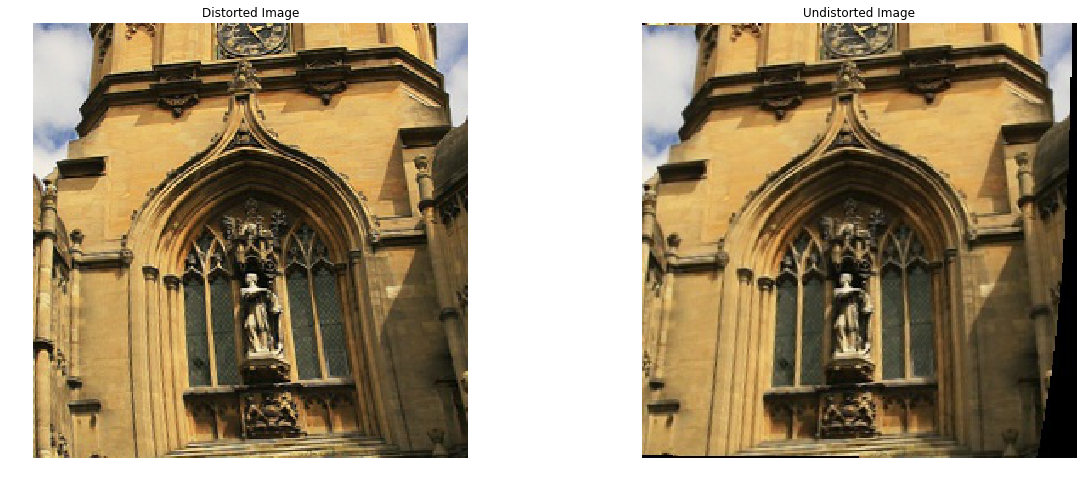

In [9]:
plt.figure(figsize=(20,8))
I = io.imread(img_path)
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(I)
plt.title('Distorted Image')
plt.subplot(1,2,2)
cv2.imwrite('tmp.jpg', target)
out = io.imread('tmp.jpg')
plt.imshow(out)
plt.axis('off')
plt.title('Undistorted Image')